In [64]:
from model.synthetic_graph import load_fork_tree
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from running import rw_directory
import random
from model.myGraph import MyGraph
from model.AMKS.amks import AMKS
from model.AMKS.amks import MultiHopAMKS
from model.WKS.wks import WKS
from running.log import get_logger
from tqdm import tqdm
from running.nodes_matching import is_Top_k
from datetime import datetime

In [65]:
custom_style = {
    'axes.prop_cycle': plt.cycler('color', ['red', 'green', 'blue']),
    'lines.linewidth': 2,
    'font.size': 12,
    'font.family': 'times new roman',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'axes.titlesize': 20,
    'legend.fontsize': 10,
    'axes.labelsize': 20,
    'axes.linewidth':2,
    'xtick.labelsize':12,
    'ytick.labelsize':12
}
plt.style.use(custom_style)


In [66]:
def get_random_graphs(num_of_node, random_sequence):
    """生成随机图"""
    # 确保可以生成图：度总和为偶数
    if np.sum(random_sequence) % 2 != 0:
        random_sequence[-1] += 1

    g = nx.configuration_model(random_sequence)
    g = nx.Graph(g)
    g.remove_edges_from(nx.selfloop_edges(g))

    degrees = dict(nx.degree(g))
    # 找出联通分量
    connected_components = [set(nodes) for nodes in nx.connected_components(g)]
    # 连接所有分量
    jointed_nodes = connected_components[0]
    # 找出两个分量中度最小的节点，加边连接
    for component in connected_components[1:]:
        min_degree_jointed = min(jointed_nodes, key=lambda x: degrees[x])
        min_degree_cur = min(component, key=lambda x: degrees[x])
        jointed_nodes = jointed_nodes | component
        g.add_edge(min_degree_jointed, min_degree_cur)
        degrees[min_degree_jointed] += 1
        degrees[min_degree_cur] += 1
    return g


In [67]:
def get_center_stable_random_graph(center_graph, outer_layer_nodes, num_of_node):
    """将多叉树和随机图进行连接，生成新的大图"""
    file_path = rw_directory.temp_file_path(4, "uniqued_degree.npy")
    uniqued_degree = np.load(file_path)
    file_path = rw_directory.temp_file_path(4, "degree_prob.npy")
    degree_prob = np.load(file_path)
    random_sequence = np.random.choice(uniqued_degree, p=degree_prob, size=len(outer_layer_nodes))
    outer_graph = get_random_graphs(num_of_node, random_sequence)

    offset = max(center_graph) + 1
    # 重新为随机图节点标注序号
    outer_graph = nx.relabel_nodes(outer_graph, {origin: origin + offset for origin in outer_graph.nodes})
    extra_edges = []

    # 随机连接多叉树的叶子节点和随机图的节点
    for node, degree in zip(outer_layer_nodes, random_sequence):
        if degree - 1 <= len(outer_graph.nodes):
            selected_nodes = random.sample(outer_graph.nodes, degree - 1)
            extra_edges.extend([(node, selected_node) for selected_node in selected_nodes])

    g = MyGraph()
    g.add_edges_from(center_graph.edges)
    g.add_edges_from(outer_graph.edges)
    # print(extra_edges)
    g.add_edges_from(extra_edges)
    return g


In [68]:
def compute_Tok(model_arg=3, times=100, index_list=None, k_list=None):
    # 随机生成图1：中心区域为多叉树图
    if k_list is None:
        k_list = [5, 10, 20]
    if index_list is None:
        index_list = [i for i in range(14)]
    center_graph, level_nodes = load_fork_tree([1, 4, 2, 2])
    center_graph.set_graph_tag("center_graph1422")

    # pos = nx.layout.kamada_kawai_layout(center_graph,scale=2)
    # nx.draw_networkx(center_graph, pos=pos)
    # plt.show()

    multiplier = 3
    outer_nodes = np.array(level_nodes[-1]).flatten().tolist()

    # print(outer_nodes)

    g = get_center_stable_random_graph(center_graph, outer_nodes, len(center_graph) * multiplier)
    tag_name = "center_stable_random_graph" + str(multiplier)
    g.set_graph_tag(tag_name)

    # pos = nx.layout.kamada_kawai_layout(g, scale=2)
    # nx.draw_networkx(g,pos=pos)
    # plt.show() 

    sigma = 1
    step = 4
    time = 0.2
    hop = 2
    model_name = ""

    if model_arg == 2:
        model_name = "WKS: "
        embed_model_one = WKS()
        embed_model_two = WKS()
    elif model_arg == 0:
        model_name = "AMKS: "
        embed_model_one = AMKS()
        embed_model_one.set_time(time)
        embed_model_two = AMKS()
        embed_model_two.set_time(time)
    else:
        model_name = "NA-AMKS: "
        embed_model_one = MultiHopAMKS()
        embed_model_one.set_maxhop(hop)
        embed_model_one.set_time(time)
        embed_model_two = MultiHopAMKS()
        embed_model_two.set_time(time)
        embed_model_two.set_maxhop(hop)

    embed_model_one.set_g(g)
    embed_model_one.set_sigma(sigma)
    embed_model_one.set_step(step)
    embed_model_one.compute_emb_vec()
    graph_one_embed_vec = embed_model_one.get_embedding_vec(sorted(g.nodes))

    embed_model_two.set_sigma(sigma)
    embed_model_two.set_step(step)

    logger = get_logger("ex4:" + model_name)
    logger.info(model_name + tag_name)
    logger.info("sigma =" + str(sigma))
    logger.info("hop =" + str(hop))
    logger.info("step =" + str(step))
    logger.info("time =" + str(time))

    hit_num = {k: {} for k in k_list}
    for index in index_list:
        for k in k_list:
            hit_num[k][index] = 0

    for i in tqdm(list(range(times))):
        # 随机生成图1：中心区域为多叉树图
        temp_g = get_center_stable_random_graph(center_graph, outer_nodes, len(center_graph) * multiplier)
        tag_name = "center_stable_random_graph_" + str(i)

        # 随机图生成2：中心区域为蜘蛛网图
        # temp_g = create_graph()  
        # temp_g = MyGraph(temp_g)
        # tag_name = "random_ "+str(i)

        temp_g.set_graph_tag(tag_name)
        embed_model_two.set_g(temp_g)
        embed_model_two.compute_emb_vec()
        graph_two_embed_vec = embed_model_two.get_embedding_vec(sorted(temp_g.nodes))

        ans = is_Top_k(graph_one_embed_vec, graph_two_embed_vec, index_list, k_list)
        for index in index_list:
            for k in k_list:
                hit_num[k][index] += ans[k][index][0]

    for index in index_list:
        logger.info("node: " + str(index))
        for k in k_list:
            logger.info("Top " + str(k) + " Score = " + str(hit_num[k][index] / times))
            print("Top " + str(k) + " Score = " + str(hit_num[k][index] / times))

    return [[hit_num[k][index] / times for index in index_list] for k in k_list]


In [69]:
def show_answer_bar(model_ans, node_list=None, k=5):
    if node_list is None:
        node_list = list(range(0, 14))
    bar_width = 0.20
    # index = range(0, 3)
    index = range(0, 2)
    pos = np.arange(len(node_list))
    labels = ['AMKS', 'NA-AMKS', 'WKS']
    colors = ['orange', 'royalblue', 'lightseagreen']

    for i in index:
        plt.bar(pos + bar_width * (i + 1), model_ans[i], width=bar_width, color=colors[i], label=labels[i])
    # plt.legend(('WKS', 'AMKS', 'NA-AMKS'), loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
    # plt.legend(('AMKS', 'NA-AMKS'), loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
    plt.legend()
    plt.xticks(pos + bar_width * 4 / 2, node_list)  # x轴的刻度
    # plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'  # 中文
    plt.rcParams["axes.unicode_minus"] = False
    # text0 = "Top_"+str(k)
    # plt.xlabel(text0)
    ## plt.title(text0)
    ## plt.text(6.5, -0.2, text0,  ha='center',va = 'center', fontsize=12)
    file_name = rw_directory.result_path(4, "RandomTop_" + str(k) + '_' + str(datetime.now()) + ".pdf")
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [70]:
def show_answer(model_ans, node_list=None, k=5):
    if node_list is None:
        node_list = list(range(0, 14))

    # index = range(0, 3)
    index = range(0, 2)
    pos = np.arange(len(node_list))
    labels = ['AMKS', 'NA-AMKS', 'WKS']
    colors = ['orange', 'royalblue', 'lightseagreen']

    for i in index:
        plt.plot(pos, model_ans[i], marker='o', c=colors[i], label=labels[i])
    # plt.legend(('WKS', 'AMKS', 'NA-AMKS'), loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
    # plt.legend(('AMKS', 'NA-AMKS'), loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
    plt.ylim((0.0, 1.1))
    plt.xlabel('Node index')
    plt.ylabel('Hit rate')
    
    plt.title(f"Top-{k}")
    plt.legend()
    # plt.xticks(pos + bar_width * 6 / 2, node_list)  # x轴的刻度
    # plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'  # 中文
    plt.rcParams["axes.unicode_minus"] = False
    plt.grid()
    # text0 = "Top_"+str(k)
    # plt.xlabel(text0)
    ## plt.title(text0)
    ## plt.text(6.5, -0.2, text0,  ha='center',va = 'center', fontsize=12)
    file_name = rw_directory.result_path(4, "RandomTop_" + str(k) + '_' + str(datetime.now()) + ".pdf")
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [71]:
def test():
    # model_list = ['AMKS', 'NA-AMKS', 'WKS']
    model_list = ['AMKS', 'NA-AMKS']
    node_list = [i for i in range(6)]

    k_list = [5, 10, 20]
    hit_num = [0] * len(model_list)
    # 计算各个模型的嵌入效果
    for i in range(len(model_list)):
        hit_num[i] = compute_Tok(model_arg=i, times=100, index_list=node_list, k_list=k_list)
    # 展示
    for k_index in range(len(k_list)):
        # 0:AMKS, 1:'NA-AMKS', 2:WKS
        model_ans = {}
        for i in range(len(model_list)):
            model_ans[i] = hit_num[i][k_index]
        print(model_ans)
        show_answer(model_ans, node_list=node_list, k=k_list[k_index])
        show_answer_bar(model_ans, node_list=node_list, k=k_list[k_index])

  9%|▉         | 9/100 [00:00<00:01, 81.03it/s]

Top 5 Score = 0.95
Top 10 Score = 1.0
Top 20 Score = 1.0
Top 5 Score = 0.5
Top 10 Score = 0.73
Top 20 Score = 0.87
Top 5 Score = 0.26
Top 10 Score = 0.65
Top 20 Score = 0.98
Top 5 Score = 0.19
Top 10 Score = 0.67
Top 20 Score = 0.99
Top 5 Score = 0.25
Top 10 Score = 0.67
Top 20 Score = 0.99
Top 5 Score = 0.3
Top 10 Score = 0.68
Top 20 Score = 0.99


100%|██████████| 100/100 [00:01<00:00, 80.43it/s]


Top 5 Score = 1.0
Top 10 Score = 1.0
Top 20 Score = 1.0
Top 5 Score = 0.99
Top 10 Score = 0.99
Top 20 Score = 1.0
Top 5 Score = 0.97
Top 10 Score = 0.99
Top 20 Score = 0.99
Top 5 Score = 0.92
Top 10 Score = 0.98
Top 20 Score = 1.0
Top 5 Score = 0.97
Top 10 Score = 0.99
Top 20 Score = 1.0
Top 5 Score = 0.96
Top 10 Score = 0.98
Top 20 Score = 0.98
{0: [0.95, 0.5, 0.26, 0.19, 0.25, 0.3], 1: [1.0, 0.99, 0.97, 0.92, 0.97, 0.96]}


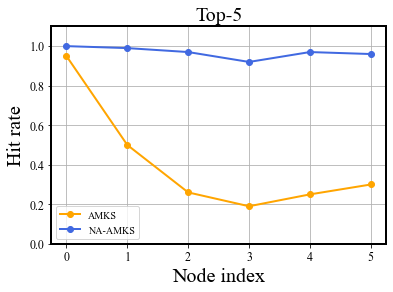

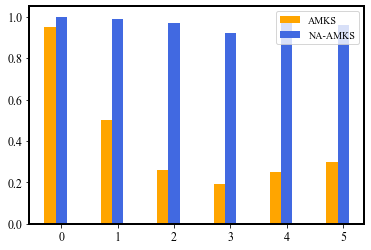

{0: [1.0, 0.73, 0.65, 0.67, 0.67, 0.68], 1: [1.0, 0.99, 0.99, 0.98, 0.99, 0.98]}


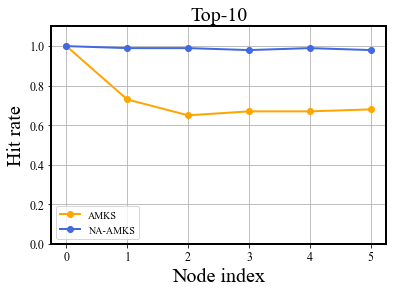

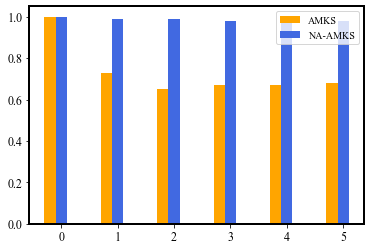

{0: [1.0, 0.87, 0.98, 0.99, 0.99, 0.99], 1: [1.0, 1.0, 0.99, 1.0, 1.0, 0.98]}


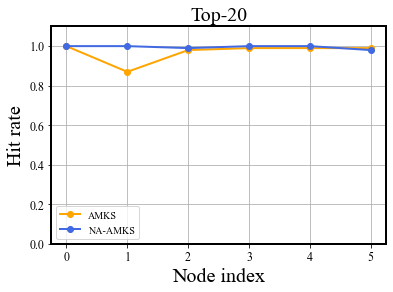

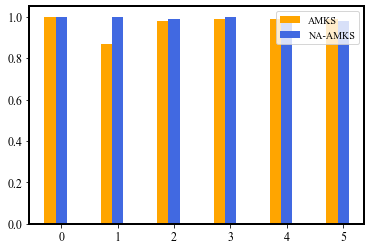

In [72]:
test()